### This program calculates the spaial error and shape error between a reference image and a drawing
- Shape Error: Measured by MSE
- Spatial Error: Rotation, Translation, Scaling

#### Load dependencies and define directory hierarchy

In [1]:
import torch as th

import matplotlib.pyplot as plt
import time

import sys
import os
from __future__ import division
import os
import urllib, cStringIO
import pymongo as pm ## first establish ssh tunnel to server where database is running
import base64
import numpy as np
from numpy import *
import PIL
from PIL import Image
import base64
import matplotlib
%matplotlib inline
from matplotlib import pylab, mlab, pyplot
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches
import cv2
import pandas as pd
from svgpathtools import parse_path
import svg_distance_helpers as rsh
import torch
from torch.autograd import Variable
import SimpleITK as sitk
#sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
import airlab as al
from torch.autograd import Variable
import affine_registration_2d as ar
from scipy.stats import pearsonr

In [2]:
# directory & file hierarchy
analysis_dir = os.getcwd()
data_dir = os.path.join(analysis_dir,"photodraw_tracing")
ref_dir = os.path.join(analysis_dir, 'tracing_ref')

loss = 'ncc'
trans_dir = os.path.join(analysis_dir, 'transformed_{}'.format(loss))

canvas_side = 432 # image size
rows, cols = canvas_side, canvas_side # the size of a given drawing image
tracing = ['this square','this shape', 'this circle']
data_output = 'photodraw_tracing_{}.csv'.format(loss)

In [3]:
# prepare lists for dataframe construction
age = []
sessionid = []
trace_item = []
pre_mse = []
post_mse = []
rotate = []
translate = []
scale = []

In [4]:
# generate reference shapes
really_run_this = 1
if really_run_this:
    ref_path = []
    for t in tracing:
        fname = os.path.join(ref_dir, '{}.png'.format(t))
        img_ref = cv2.imread(fname)
        img_ref = rsh.color_to_num(img_ref, threshold=0, white_background=False)
        ofname = os.path.join(ref_dir, '{}_ref.png'.format(t))
        cv2.imwrite(ofname, 255-img_ref*255)
        ref_path.append(ofname)
    

In [5]:
reload(al)
reload(ar)
# get tracings from the data folder
for child_dir in os.listdir(data_dir):
    if child_dir.startswith('CDM'):
        child_info = child_dir.split('_')
        c_age = int(child_info[-1].replace('age',''))
        c_sessionid = child_info[2]

        for ti, t in enumerate(tracing):
            img_draw = os.path.join(data_dir, child_dir, '{}.png'.format(t))
            
            if os.path.exists(img_draw):
                img_ref = ref_path[ti]
                output_path = os.path.join(trans_dir, '{}_{}_wrap.png'.format(c_sessionid, t))
                init_loss, final_loss, ro, tran, s, warped = ar.affine_reg(img_draw, img_ref, output_path)
                #cv2.imwrite(os.path.join(trans_dir,output_path), warped.numpy()*255)
                
                # prepare the dataframe
                age.append(c_age)
                sessionid.append(c_sessionid)
                trace_item.append(t)
                pre_mse.append(init_loss)
                post_mse.append(final_loss)
                rotate.append(ro)
                translate.append(tran)
                scale.append(s)

In [6]:
print age

[7, 7, 7, 4, 4, 5, 5, 5, 7, 7, 7, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 7, 7, 7, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 4, 4, 4, 6, 6, 6, 7, 7, 7, 6, 6, 6, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 7, 7, 7, 5, 5, 5, 6, 6, 6, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4]


In [7]:
really_run_this = 1 
## compile data
if really_run_this:
    data = pd.DataFrame([sessionid, age, trace_item, pre_mse, post_mse, rotate, translate, scale])
    data = data.transpose()
    data.columns = ['session_id','age', 'tracing_item', 'pre_tran', 'post_tran', 'rotate', 'translate', 'scale']
    
## save out the data
data.to_csv(data_output)

#### Data Visualization

In [ ]:
really_run_this = 1 

if really_run_this:
    data = pd.read_csv(data_output)

- X axis: Age        
- Y axis: pre/post-mse

In [ ]:
#ylim = (0, 0.1)   # mse
ylim = (-0.8, 0.1)
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    age = []
    mse_list = []
    current_trace = data.loc[(data['tracing_item'] == t)]
    
    for index, row in current_trace.iterrows():
        age.append(row['age'])
        mse_list.append(row['pre_mse'])
    
    plt.subplot(1,3,ti+1)
    h = plt.scatter(age, mse_list)
    plt.ylabel(t +' pre-mse')
    plt.xlabel('age')
    plt.ylim(ylim)
    
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    age = []
    mse_list = []
    current_trace = data.loc[(data['tracing_item'] == t)]
    
    for index, row in current_trace.iterrows():
        age.append(row['age'])
        mse_list.append(row['post_mse'])
    
    plt.subplot(1,3,ti+1)
    h = plt.scatter(age, mse_list)
    plt.ylabel(t +' post-mse')
    plt.xlabel('age')
    plt.ylim(ylim)


- X axis: Pre-mse
- Y axis: Post-mse  
- Age: different colors

In [ ]:
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    plt.subplot(1,3,ti+1)
    plt.ylabel(t +' post-mse')
    plt.xlabel('pre-mse')
    plt.xlim((0.0, 0.1))
    plt.ylim((0.0, 0.1))
    
    for age in range(4, 8):
        current_trace = data.loc[(data['age'] == age) &(data['tracing_item'] == t)]
        pre_mse_list = []
        post_mse_list = []
        
        for index, row in current_trace.iterrows():
            pre_mse_list.append(row['pre_mse'])
            post_mse_list.append(row['post_mse'])

        h = plt.scatter(pre_mse_list, post_mse_list, label='age'+str(age))
    
    plt.legend()


- X axis: Age        
- Y axis: rotation

In [ ]:
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    age = []
    mse_list = []
    current_trace = data.loc[(data['tracing_item'] == t)]
    
    for index, row in current_trace.iterrows():
        age.append(row['age'])
        mse_list.append(row['rotate'])
    
    plt.subplot(1,3,ti+1)
    h = plt.scatter(age, mse_list)
    plt.ylabel(t +' rotation')
    plt.xlabel('age')
    plt.ylim((0.0, 0.2))

- X axis: Age        
- Y axis: translation

In [ ]:
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    age = []
    mse_list = []
    current_trace = data.loc[(data['tracing_item'] == t)]
    
    for index, row in current_trace.iterrows():
        age.append(row['age'])
        mse_list.append(row['translate'])
    
    plt.subplot(1,3,ti+1)
    h = plt.scatter(age, mse_list)
    plt.ylabel(t +' translation')
    plt.xlabel('age')
    plt.ylim((0.0, 0.25))

- X axis: Age
- Y axis: Scaling

In [ ]:
plt.figure(figsize=(18,5))
plt.subplots_adjust(wspace=0.3)

for ti, t in enumerate(tracing):
    age = []
    mse_list = []
    current_trace = data.loc[(data['tracing_item'] == t)]
    
    for index, row in current_trace.iterrows():
        age.append(row['age'])
        mse_list.append(row['scale'])
    
    plt.subplot(1,3,ti+1)
    h = plt.scatter(age, mse_list)
    plt.ylabel(t +' scale')
    plt.xlabel('age')
    plt.ylim((0, 1.2))

#### Tracing and Recognition

In [ ]:
# get recognition correction percentage
recog = pd.read_csv('photodraw_recognition_ratings.csv')
all_sessions = data.session_id.unique()

data['correct'] = 0
data['condition'] = 'None'

for index, id in enumerate(all_sessions):
    rec_col = recog.loc[(recog['sessionId'] == id)]
    if rec_col.shape[0] == 0:
        data.loc[data['session_id'] == id, ['correct']] = 0
        continue
    current_condition = rec_col['condition'].iloc[0]
    rec_correct_percent = rec_col.loc[(rec_col['correct'])].shape[0]/rec_col.shape[0]
    data.loc[data['session_id'] == id, ['correct']] = rec_correct_percent
    data.loc[data['session_id'] == id, ['condition']] = current_condition

data.to_csv("photodraw_tracing.csv")

In [ ]:


for ci, c in enumerate(['S','W','P']):
    plt.figure(figsize=(18,5))
    plt.subplots_adjust(wspace=0.3)
    for ti, t in enumerate(tracing):
        plt.subplot(1,3,ti+1)
        plt.ylabel(c + ' correct percent')
        plt.xlabel(t +' post-mse')
        plt.xlim(0.0,0.1)
        plt.ylim(0.0,1.0)
        
        for age in range(4, 8):
            current_trace = data.loc[(data['age'] == age) &(data['tracing_item'] == t) & (data['condition'] == c)]
            post_mse_list = []
            correct = []

            for index, row in current_trace.iterrows():
                post_mse_list.append(row['post_mse'])
                correct.append(row['correct'])

            h = plt.scatter(post_mse_list, correct, label='age'+str(age))
    
        plt.legend()



#### Evaluate whether the overall metric captures human judgment intuitions

In [ ]:
# Overlap the drawing on reference images

overlap_dir = os.path.join(analysis_dir, 'overlap')
# get tracings from the data folder
for child_dir in os.listdir(data_dir):
    if child_dir.startswith('CDM'):
        child_info = child_dir.split('_')
        c_age = int(child_info[-1].replace('age',''))
        c_sessionid = child_info[2]

        for ti, t in enumerate(tracing):
            img_draw = os.path.join(data_dir, child_dir, '{}.png'.format(t))
            
            if os.path.exists(img_draw):
                img_ref = ref_path[ti]
                output_path = '{}_{}_{}_{}_overlap.png'.format(c_sessionid, ti, t, c_age)
                
                draw = cv2.imread(img_draw).astype(int16)
                ref = cv2.imread(img_ref).astype(int16)
                ref[ref<255] = 150
                img = np.add(draw, ref) /2
                
                cv2.imwrite(os.path.join(overlap_dir,output_path), img)
                

In [ ]:
really_run_this = 1 

if really_run_this:
    data = pd.read_csv(data_output)

In [8]:
# convert three spatial errors into one single number
# 1. normalize rotation, scaling, and translation
data['norm_r'] = (data['rotate'] - data['rotate'].mean())/data['rotate'].std()
data['norm_t'] = (data['translate'] - data['translate'].mean())/data['translate'].std()
data['norm_s'] = (data['scale'] - data['scale'].mean())/data['scale'].std()

# 2. summarize the three varaibles
w_r, w_t, w_s = 1, 1, 1
data['spatial'] = data['norm_r'] * w_r + data['norm_t'] * w_t + data['norm_s'] * w_s
data.to_csv(data_output)


In [9]:
rating = pd.read_csv('photodraw_tracing_rating.csv')
spatial_error = data['spatial']
shape_error = data['post_tran']
rater1 = rating['rater1']

norm_spatial = (spatial_error - np.mean(spatial_error))/np.std(spatial_error)
norm_shape = (shape_error - np.mean(shape_error))/np.std(shape_error)
overall_error = norm_spatial + norm_shape

spatial_cor = pearsonr(spatial_error, rater1)
shape_cor = pearsonr(shape_error, rater1)
overall_cor = pearsonr(overall_error, rater1)

print 'MSE loss'
print 'correlate human judgments with spatial errors: r = {}, p = {}'.format(spatial_cor[0], spatial_cor[1])
print 'correlate human judgments with shape errors: r = {}, p = {}'.format(shape_cor[0], shape_cor[1]) 
print 'correlate human judgments with shape+spatial errors: r = {}, p = {}'.format(overall_cor[0], overall_cor[1])


MSE loss
correlate human judgments with spatial errors: r = -0.632933824445, p = 1.62538286332e-19
correlate human judgments with shape errors: r = -0.690665634393, p = 2.72843521162e-24
correlate human judgments with shape+spatial errors: r = -0.811900272108, p = 3.09114988068e-39


In [10]:
data['rater1'] = rater1
data.to_csv('photodraw_summary_{}.csv'.format(loss))

#### Compare different loss

Text(0.5,0,'NCC Spatial Error')

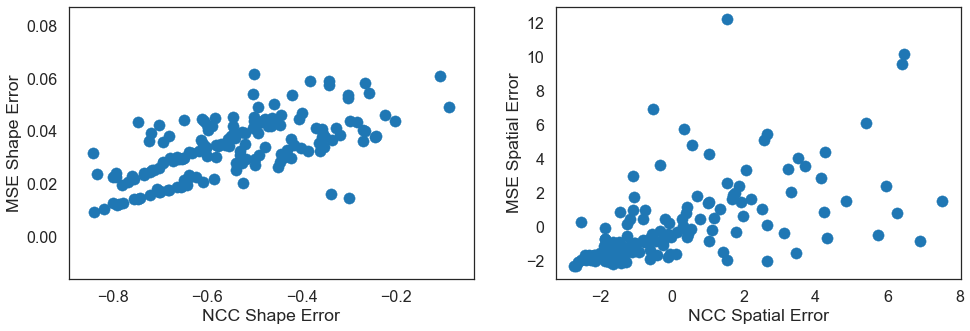

In [49]:
xlim = (-1,0)
ylim = (0, 0.08)

ncc = pd.read_csv('photodraw_tracing_ncc.csv')
mse = pd.read_csv('photodraw_tracing_mse.csv')

ncc_shape, ncc_spatial, ncc_overall = [], [], []
mse_shape, mse_spatial, mse_overall = [], [], []

for s in all_sessions:
    current_ncc = ncc.loc[(ncc['session_id'] == s)]
    
    for index, draw in current_ncc.iterrows():
        ncc_shape.append(draw['post_tran'])
        ncc_spatial.append(draw['spatial'])
        ncc_overall.append(draw['post_tran'] + draw['spatial'])
        
        current_mse = mse.loc[(mse['session_id'] == s) & (mse['tracing_item'] == draw['tracing_item'])]
        mse_shape.append(current_mse['post_tran'].item())
        mse_spatial.append(current_mse['spatial'].item())
        mse_overall.append(current_mse['post_tran'].item() + current_mse['spatial'].item())


plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
h = plt.scatter(ncc_shape, mse_shape)
plt.ylabel('MSE Shape Error')
plt.xlabel('NCC Shape Error')

plt.subplot(1,2,2)
h = plt.scatter(ncc_spatial, mse_spatial)
plt.ylabel('MSE Spatial Error')
plt.xlabel('NCC Spatial Error')


In [52]:
shape_loss_cor = pearsonr(ncc_shape, mse_shape)
spatial_loss_cor = pearsonr(ncc_spatial, mse_spatial)
overall_loss_cor = pearsonr(ncc_overall, mse_overall)

print "NCC loss vs. MSE loss Pearson'r Correlation"
print 'correlate NCC shape error with MSE shape errors: r = {}, p = {}'.format(shape_loss_cor[0], shape_loss_cor[1])
print 'correlate NCC spatial error with MSE spatial errors: r = {}, p = {}'.format(spatial_loss_cor[0], spatial_loss_cor[1])
print 'correlate NCC overall error with MSE overall errors: r = {}, p = {}'.format(overall_loss_cor[0], overall_loss_cor[1])



NCC loss vs. MSE loss Pearson'r Correlation
correlate NCC shape error with MSE shape errors: r = 0.651446423074, p = 6.20128017038e-21
correlate NCC spatial error with MSE spatial errors: r = 0.599337686941, p = 3.58396749875e-17
correlate NCC overall error with MSE overall errors: r = 0.615863090065, p = 2.73326812751e-18
